## Traveling Salesman Problem and GA

Following from: https://towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35

In [1]:
%matplotlib notebook
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt
from collections import Counter

In [2]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"
    
    def __lt__(self, other):
        if self.x < other.x:
            return True
        elif self.x == other.x and self.y < other.y:
            return True
        else:
            return False

In [3]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

In [4]:
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

In [5]:
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

In [6]:
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

In [7]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

In [8]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

In [9]:
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

In [10]:
#Partially Mapped Crossover method of recombination/child generation
def PMX(parent1, parent2):
    child = [None] * len(parent1)
    
    #Choose 2 crossover points at random
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)
    
    tmpIndex = 0
    i = None #Holds the gene in parent2 that needs placed
    j = None #Holds the gene in parent1 that is in the place i was in parent 2
    k = None #Used to find a position to place i in the child
    
    for index in range(startGene, endGene):
        child[index] = parent1[index]
        
        if parent2[index] not in parent1[startGene:endGene]:
            i = parent2[index]
            j = parent1[index]
            tmpIndex = parent2.index(j)
            
            while startGene <= tmpIndex and tmpIndex < endGene:
                k = parent1[tmpIndex]
                tmpIndex = parent2.index(k)

            child[tmpIndex] = i
            
    for index in range(0, len(parent2)):
        if child[index] == None:
            child[index] = parent2[index]
                
    return child


In [11]:
def CalcIndex(lst, cIndex):
    
    lIndex = cIndex - 1
    rIndex = cIndex + 1
        
    if lIndex < 0:
        lIndex = len(lst) - 1
            
    if rIndex >= len(lst):
        rIndex = 0
        
    dictry = {"left":lIndex, "right":rIndex}
        
    return dictry

In [12]:
def GenerateEdgeTable(parent1, parent2):
    edges = {x: [] for x in parent1}
    
    cIndex = None
    sideIn = None
    
    for index in range(0, len(parent1)):
        sideIn = CalcIndex(parent1, index)
        
        #print(f"cIndex: {index}, lIndex: {sideIn['left']}, rIndex: {sideIn['right']}\n")
        
        edges[parent1[index]].append(parent1[sideIn["left"]])
        edges[parent1[index]].append(parent1[sideIn["right"]])
        
        cIndex = parent2.index(parent1[index])
        sideIn = CalcIndex(parent2, cIndex)
        
        edges[parent1[index]].append(parent2[sideIn["left"]])
        edges[parent1[index]].append(parent2[sideIn["right"]])
        
    return edges

In [13]:
def FindShortestListKey(lst, edges, child):
    #NOTE: Given that I allow there to be multiple instances of an element in the lists to signify a common edge,
    #          I need to remove the duplicate edges when checking their length
    shortest = []
    size = None
    item = None
    rmDups = None
    
    for key in lst:
        if key not in child: #Might not need anymore
            rmDups = Counter(edges[key])  
            
            if size == None:
                size = len(rmDups)
                shortest.append(key)

            elif len(rmDups) > 0 and len(rmDups) < size:
                size = len(rmDups)
                shortest = [key]

            elif len(rmDups) == size:
                shortest.append(key)

    if len(shortest) > 1:
        item = random.choice(shortest)
                    
    else:
        item = shortest[0]
    
    return item

In [14]:
#Edge Crossover method of recombination/child generation
def EX(parent1, parent2):
    child = []
    
    #A dictionary with each city as a key that connects to a list of its edges
    edges = None
    
    #Used to create child
    entry = None
    currElement = None
    count = None
    i = 0
    unused = []
    
    #1) Construct Edge Table
    edges = GenerateEdgeTable(parent1, parent2)
    
    #2) Pick a initial element @ random & put in offspring
    entry = random.choice(list(edges))
    child.append(entry)
    
    
    #3) Set the variable current_element = entry
    currElement = entry
    
    while len(child) < len(parent1):
    
        #4) Remove all references to current_element from table
        for key in edges:
            try:
                #NOTE: Should look for a cleaner/better solution
                while True:
                    edges[key].remove(currElement)
                    
            except ValueError:
                pass
        
        #5) Examine list for current_element
        #NOTE: Ties are split at random
        if len(edges[currElement]) != 0:
            count = Counter(edges[currElement]).most_common()
            
            #5.1) If there is a common edge, pick that to be the next element
            if count[0][1] == 2:
                i = 1

                while i < len(count) and count[i][1] == 2:
                    i += 1
                
                entry = random.choice(count[0:i])[0]
                
                while entry in child:
                    entry = random.choice(count[0:i])[0]
                    
                currElement = entry

            #5.2) Otherwise, pick the entry in the list which itself has the shortest list
            else:
                currElement = FindShortestListKey(edges[currElement], edges, child)

        #6) In the case of reaching an empty list, a new element is chosen at random
        else:
            unused = [item for item in parent1 if item not in child]
            
            currElement = random.choice(unused)
        
        #Reset Variables
        i = 0
        unused = []
        
        child.append(currElement)
    
    return child

In [15]:
#Order Crossover method of recombination/child generation
def OX(parent1, parent2):
    child = [None] * len(parent1)
    notAdded = None
    
    #Choose 2 crossover points at random
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)
    p2Index = endGene
    cpIndex = endGene
    
    #Copy over segment from parent1 into child
    for index in range(startGene, endGene):
        child[index] = parent1[index]
        
    #Start from the end of the crossover point in parent 2 and copy over any elements not currently in child
    notAdded = [item for item in parent2 if item not in child]
    
    for i in range(0, len(notAdded)):
        if parent2[p2Index] not in child:
            if child[cpIndex] != None:
                while child[cpIndex] != None:
                    cpIndex += 1
                    
                    if cpIndex >= len(child):
                        cpIndex = 0
                        
        else:
            while parent2[p2Index] in child:
                p2Index += 1
                    
                if p2Index >= len(parent2):
                    p2Index = 0  
                            
        child[cpIndex] = parent2[p2Index]
                
            
        p2Index += 1
        cpIndex += 1
        
        if p2Index >= len(parent2):
            p2Index = 0
        
        if cpIndex >= len(child):
            cpIndex = 0
        
    return child

In [16]:
def breedPopulation(matingpool, eliteSize, childMethod):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        #child = breed(pool[i], pool[len(matingpool)-i-1])
        if childMethod == 0:
            child = PMX(pool[i], pool[len(matingpool) - i - 1])
        elif childMethod == 1:
            child = EX(pool[i], pool[len(matingpool) - i - 1])
        elif childMethod == 2:
            child = OX(pool[i], pool[len(matingpool) - i - 1])
           
        children.append(child)
    return children

In [17]:
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

In [18]:
def SwapMutation(individual, mutationRate):
    newIndividual = individual.copy()
    
    if(random.random() < mutationRate):
        index1, index2 = random.choices(range(len(newIndividual)),k=2)
            
        newIndividual[index1] = individual[index2]
        newIndividual[index2] = individual[index1]
    return newIndividual

In [19]:
def InversionMutation(individual, mutationRate):
    index1 = None
    index2 = None
    smallIndex = None
    bigIndex = None
    index = 0
    
    gene1 = None
    gene2 = None
    
    if(random.random() < mutationRate):
        #Randomly selects the section of the chromosome to reverse
        index1 = random.randint(0, len(individual) - 1)
        index2 = random.randint(0, len(individual) - 1)

        smallIndex = min(index1, index2)
        bigIndex = max(index1, index2)
        
        swapped = smallIndex + index
        swapWith = bigIndex - index
        
        while swapped < swapWith:
            
            gene1 = individual[swapped]
            gene2 = individual[swapWith]

            individual[swapped] = gene2
            individual[swapWith] = gene1
            
            index += 1
            swapped = smallIndex + index
            swapWith = bigIndex - index
        
    return individual

In [20]:
def mutatePopulation(population, mutationRate, mutMethod):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        #mutatedInd = mutate(population[ind], mutationRate)
        if mutMethod == 0:
            mutatedInd = population[ind]
        elif mutMethod == 1:
            mutatedInd = SwapMutation(population[ind], mutationRate)
        elif mutMethod == 2:
            mutatedInd = InversionMutation(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
        
    return mutatedPop

In [21]:
def nextGeneration(currentGen, eliteSize, mutationRate, childMethod, mutMethod):
    popRanked = rankRoutes(currentGen)
#    for i in popRanked:
#        print(i)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
#    for i in matingpool:
#        print(i)
    children = breedPopulation(matingpool, eliteSize, childMethod)
    nextGeneration = mutatePopulation(children, mutationRate, mutMethod)
    return nextGeneration

In [86]:
def DetermineChange(value, generation, reset = False):
    #Makes orig function like a "static" variable and remain between function calls
    if 'orig' not in DetermineChange.__dict__:
        DetermineChange.orig = (value, generation)
        
    if DetermineChange.orig == None:
        DetermineChange.orig = (value, generation)
        
    proceed = True
        
    if reset:
        DetermineChange.orig = None
        
    else:
        perc = abs(DetermineChange.orig[0] - value) / DetermineChange.orig[0]

        #print(f"orig: {DetermineChange.orig}\nnew: ({value}, {generation})")
        #print(f"perc: {perc}")

        if perc < perChange and abs(DetermineChange.orig[1] - generation) >= maxFlatGens:
            proceed = False
        elif perc > perChange:
                DetermineChange.orig = (value, generation)
                
    return proceed

In [22]:
#def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
def geneticAlgorithm(population, eliteSize, mutationRate, generations):
    #pop = initialPopulation(popSize, population)
    pop = population
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
    
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

In [23]:
def geneticAlgorithmComparison(population, eliteSize, mutationRate, generations, childMethods, mutationMethods):
    #pop = initialPopulation(popSize, population)
    pop = population
    #print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    for cMethod in childMethods:
        for mMethod in mutationMethods:
            print(childMethods[cMethod] + "," + mutationMethods[mMethod])
            print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
            for i in range(0, generations):
                pop = nextGeneration(pop, eliteSize, mutationRate, cMethod, mMethod)
            
            print("Final distance: " + str(1 / rankRoutes(pop)[0][1]) + "\n\n")
            pop = population
    
    #print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

In [24]:
#def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
def geneticAlgorithmPlot(population, eliteSize, mutationRate, generations):
    #pop = initialPopulation(popSize, population)
    pop = population
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
    
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()

In [31]:
def geneticAlgorithmComparisonPlot(population, eliteSize, mutationRate, generations, childMethods, mutationMethods):
    #pop = initialPopulation(popSize, population)
    pop = population
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    label = None
    df = pd.DataFrame()
    
    for cMethod in childMethods:
        for mMethod in mutationMethods:
            label = childMethods[cMethod] + "," + mutationMethods[mMethod]
    
            #Change to while loop and add early termination condition
            for i in range(0, generations):
                pop = nextGeneration(pop, eliteSize, mutationRate, cMethod, mMethod)
                progress.append(1 / rankRoutes(pop)[0][1])
                
            df[label] = progress
            pop = population
            progress = []
            progress.append(1 / rankRoutes(pop)[0][1])
    
    plt.plot(df)
    plt.title(f"Pop={len(population)}, Elite Size={eliteSize}, Mutation Rate={mutationRate}, Generations={generations}")
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.legend(df, loc = "center left", bbox_to_anchor=(1, 0.5), title="Configurations")
    plt.tight_layout()
    plt.show()

In [ ]:
def geneticAlgorithmPerformanceTest(population, eliteSize, mutationRate, generations, childMethod, mutationMethod, runs):
    pop = population
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    label = None
    tmpDF = pd.DataFrame()
    df = pd.DataFrame()
    j = 0
    
    for i in range(runs):
        label = f"Run {i}"
    
        while(j < generations and DetermineChange(progress[j], j)):
            pop = nextGeneration(pop, eliteSize, mutationRate, childMethod, mutationMethod)
            progress.append(1 / rankRoutes(pop)[0][1])
            j += 1
            
        DetermineChange(999, 999, True)
                
        tmpDF[label] = progress
        df = pd.concat([df, tmpDF], axis = 1)
        
        tmpDF = pd.DataFrame()
        pop = population
        progress = []
        progress.append(1 / rankRoutes(pop)[0][1])
        j = 0
    
    plt.plot(df)
    plt.title(f"""{childMethods[childMethod]} and {mutationMethods[mutationMethod]}\n
                Pop={len(population)}, Elite Size={eliteSize}, Mutation Rate={mutationRate}, Generations={generations}""")
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.legend(df, loc = "center left", bbox_to_anchor=(1, 0.5), title="Runs")
    plt.tight_layout()
    plt.show()

In [189]:
def geneticAlgorithmVariationTest(population, eliteSize, mutationRate, generations, childMethod, mutationMethod, runs):
    #pop = initialPopulation(popSize, population)
    pop = population
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    label = None
    tmpDF = pd.DataFrame()
    df = pd.DataFrame()
    dfErr = pd.DataFrame()
    j = 0
    
    for i in range(runs):
        label = f"Run {i}"
    
        while(j < generations and DetermineChange(progress[j], j)):
            pop = nextGeneration(pop, eliteSize, mutationRate, childMethod, mutationMethod)
            progress.append(1 / rankRoutes(pop)[0][1])
            j += 1
            
        DetermineChange(999, 999, True)
                
        tmpDF[label] = progress
        df = pd.concat([df, tmpDF], axis = 1)
        
        tmpDF = pd.DataFrame()
        pop = population
        progress = []
        progress.append(1 / rankRoutes(pop)[0][1])
        j = 0
        
    dfErr = df.std(axis = 0) / np.sqrt(1/len(df) + df - df.mean(axis = 0)**2 / np.sum((df - df.mean(axis = 0)**2)))
    
    #(x - x.mean())**2 / np.sum((x - x.mean())**2))
    
    plt.plot(df)
    plt.title(f"""{childMethods[childMethod]} and {mutationMethods[mutationMethod]}\n
                Pop={len(population)}, Elite Size={eliteSize}, Mutation Rate={mutationRate}, Generations={generations}""")
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.legend(df, loc = "center left", bbox_to_anchor=(1, 0.5), title="Runs")
    
    for column in df:
        plt.fill_between(df.index, df[column] - dfErr[column], df[column] + dfErr[column], alpha = 0.2)
    
    plt.tight_layout()
    plt.show()

In [26]:
cityList = []

for i in range(0,25):
    cityList.append(City(x=int(random.random() * 200), y=int(random.random() * 200)))

In [67]:
popSize = 100
eliteSize = 20
mutationRate = 0.05
generations = 500
perChange = 0.05
maxFlatGens = 50

In [28]:
childMethods = {0:"PMX", 1:"EX", 2:"OX"}
mutationMethods = {0:"None", 1:"Swap", 2:"Inversion"}

In [29]:
#Generate a population for testing
pop = initialPopulation(popSize = popSize, cityList = cityList)

<IPython.core.display.Javascript object>


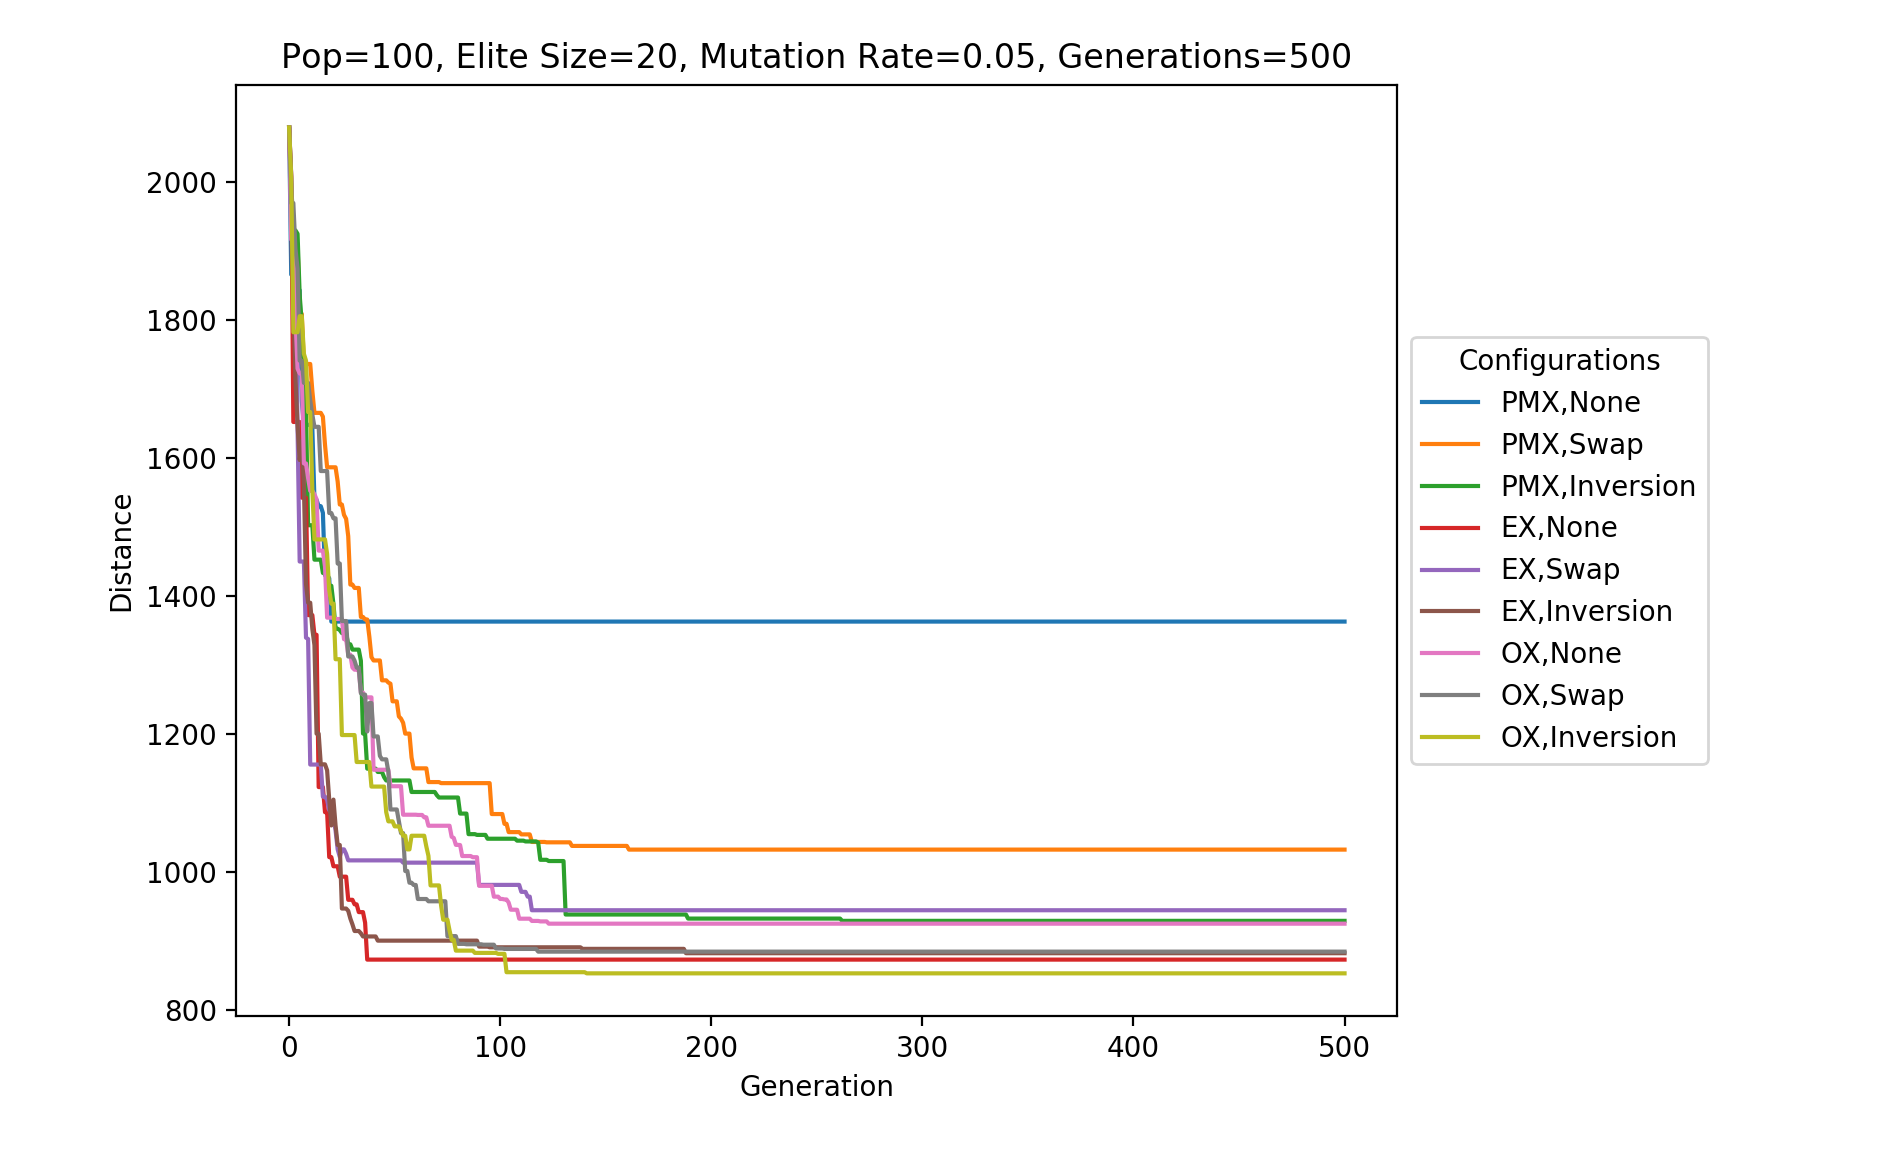

In [36]:
geneticAlgorithmComparisonPlot(population=pop, eliteSize=eliteSize, mutationRate=mutationRate, generations=generations,
                               childMethods = childMethods, mutationMethods = mutationMethods)

<IPython.core.display.Javascript object>


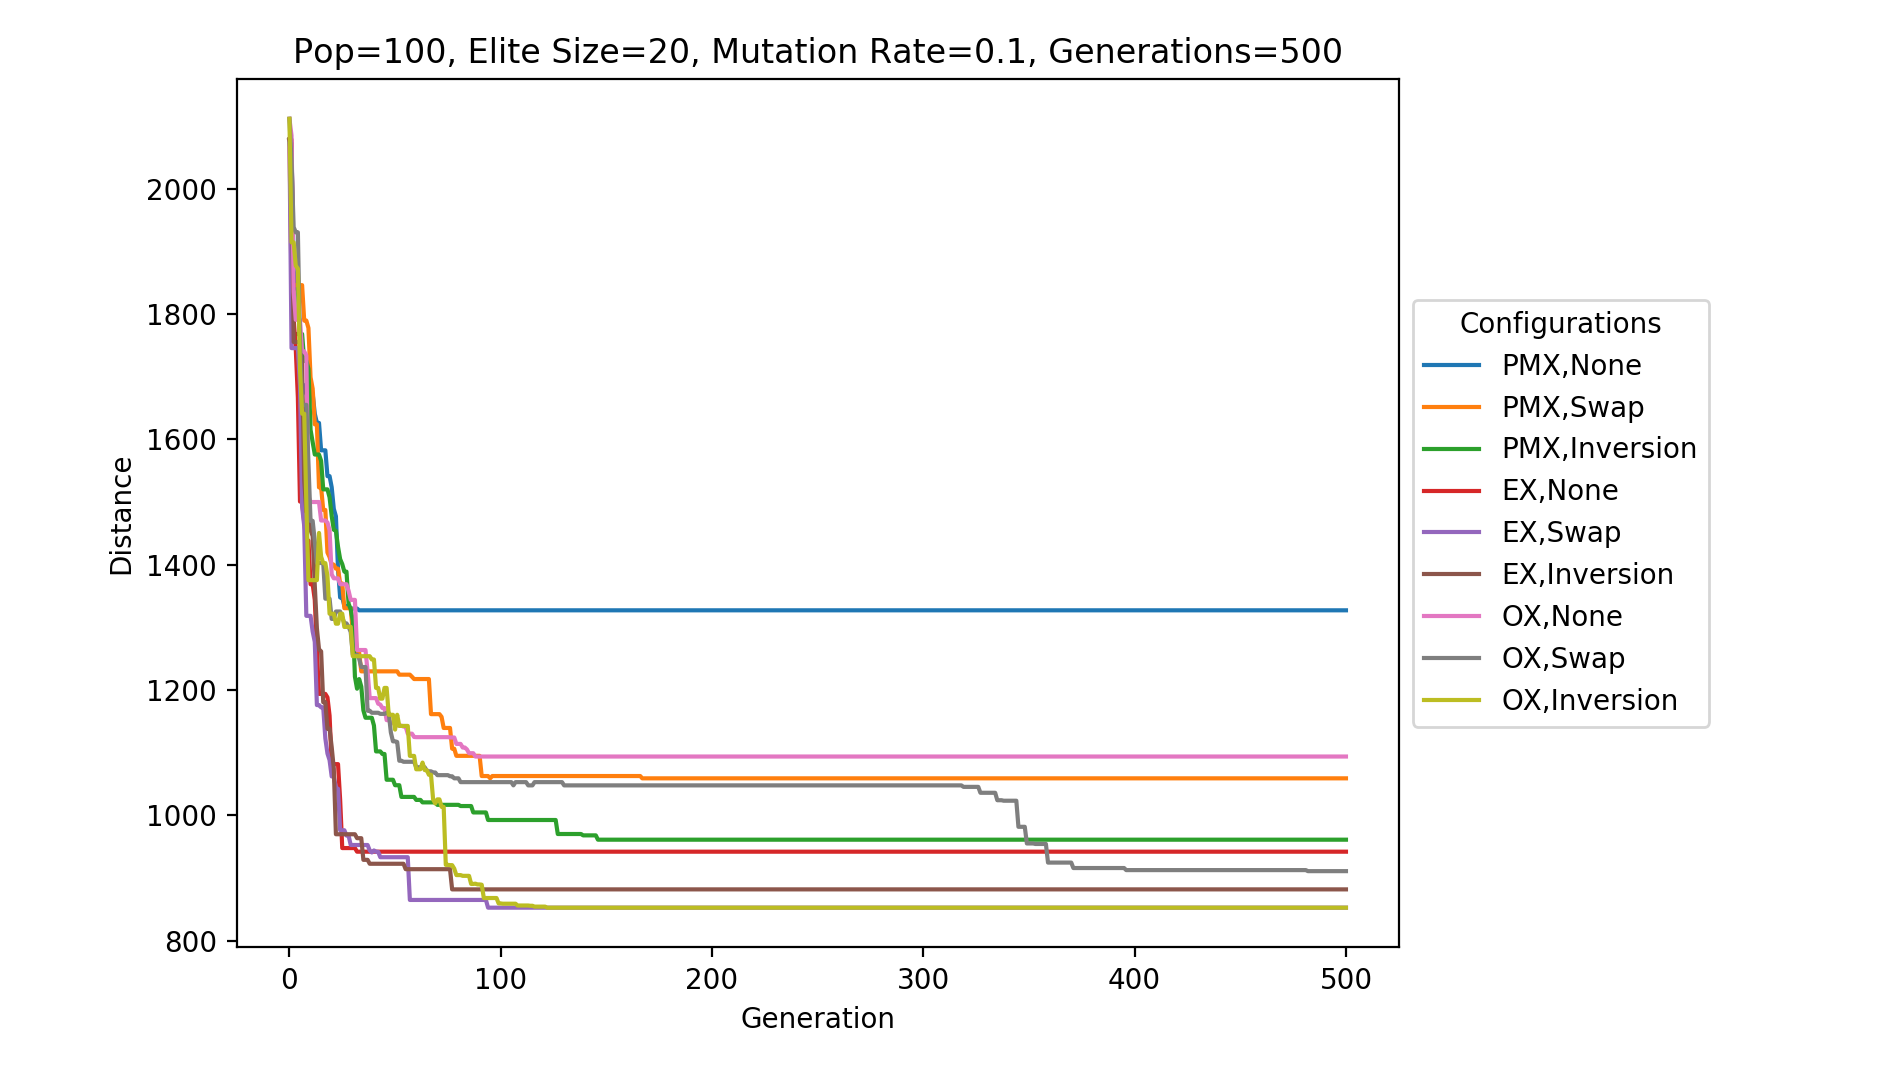

In [37]:
geneticAlgorithmComparisonPlot(population=pop, eliteSize=eliteSize, mutationRate=0.1, generations=generations,
                               childMethods = childMethods, mutationMethods = mutationMethods)

<IPython.core.display.Javascript object>


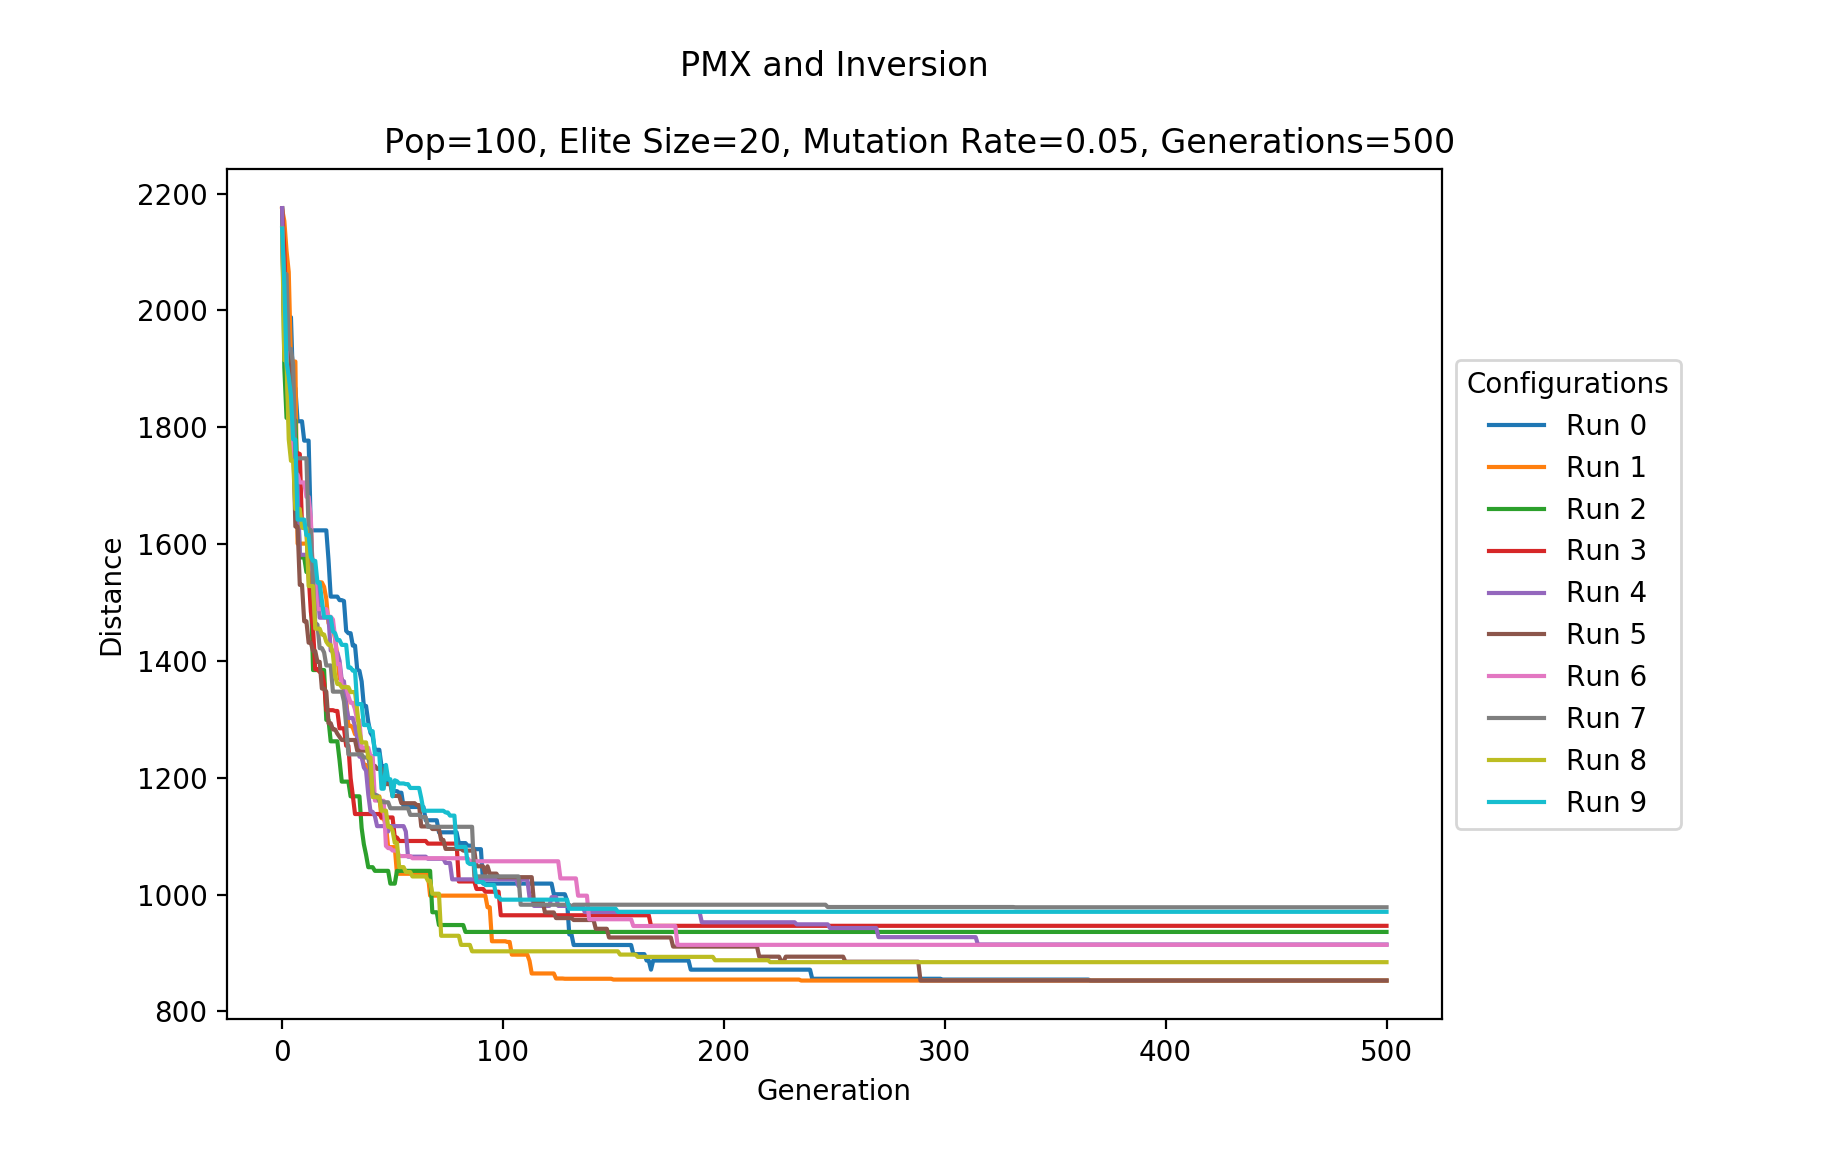

In [60]:
geneticAlgorithmVariationTest(population=pop, eliteSize=eliteSize, mutationRate=mutationRate, generations=generations, 
                              childMethod=0, mutationMethod=2, runs=10)

<IPython.core.display.Javascript object>


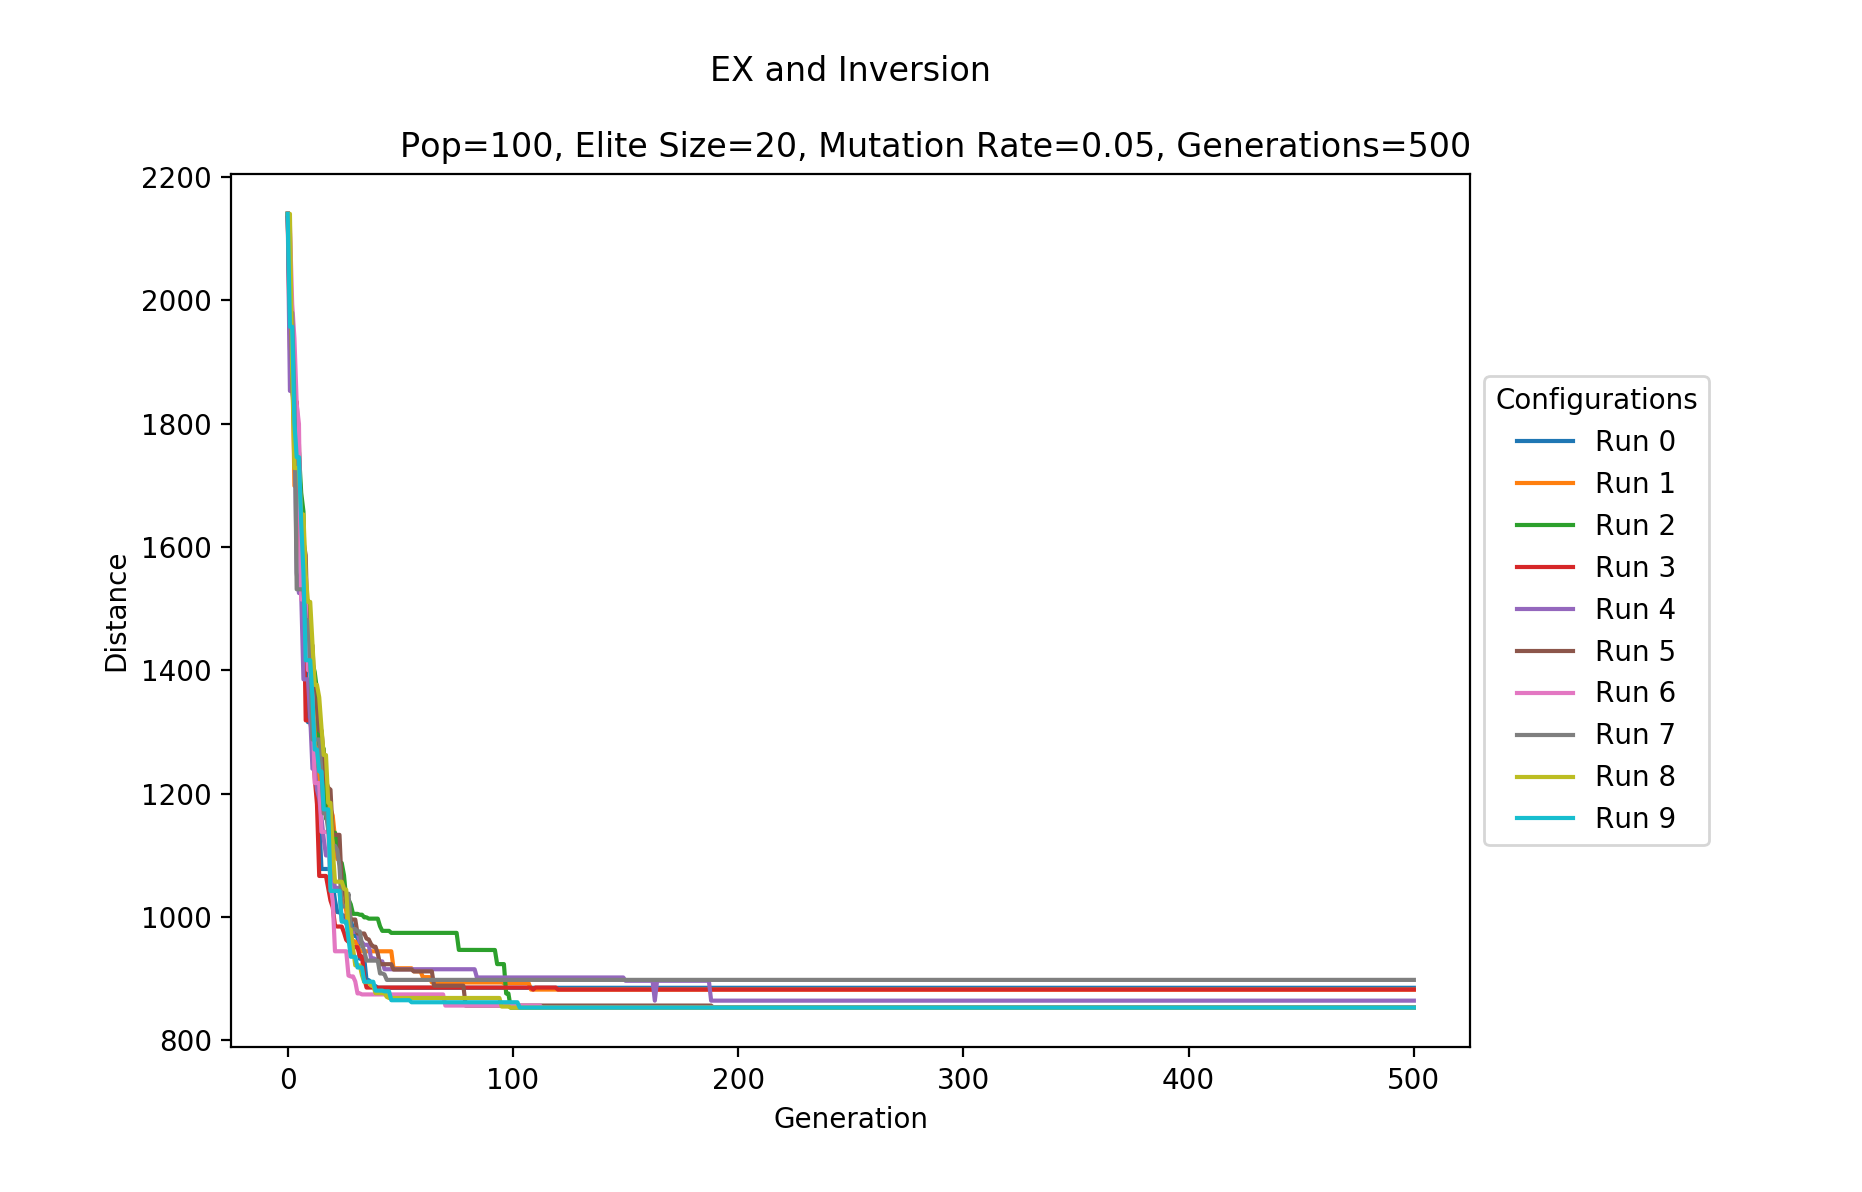

In [61]:
geneticAlgorithmVariationTest(population=pop, eliteSize=eliteSize, mutationRate=mutationRate, generations=generations, 
                              childMethod=1, mutationMethod=2, runs=10)

<IPython.core.display.Javascript object>


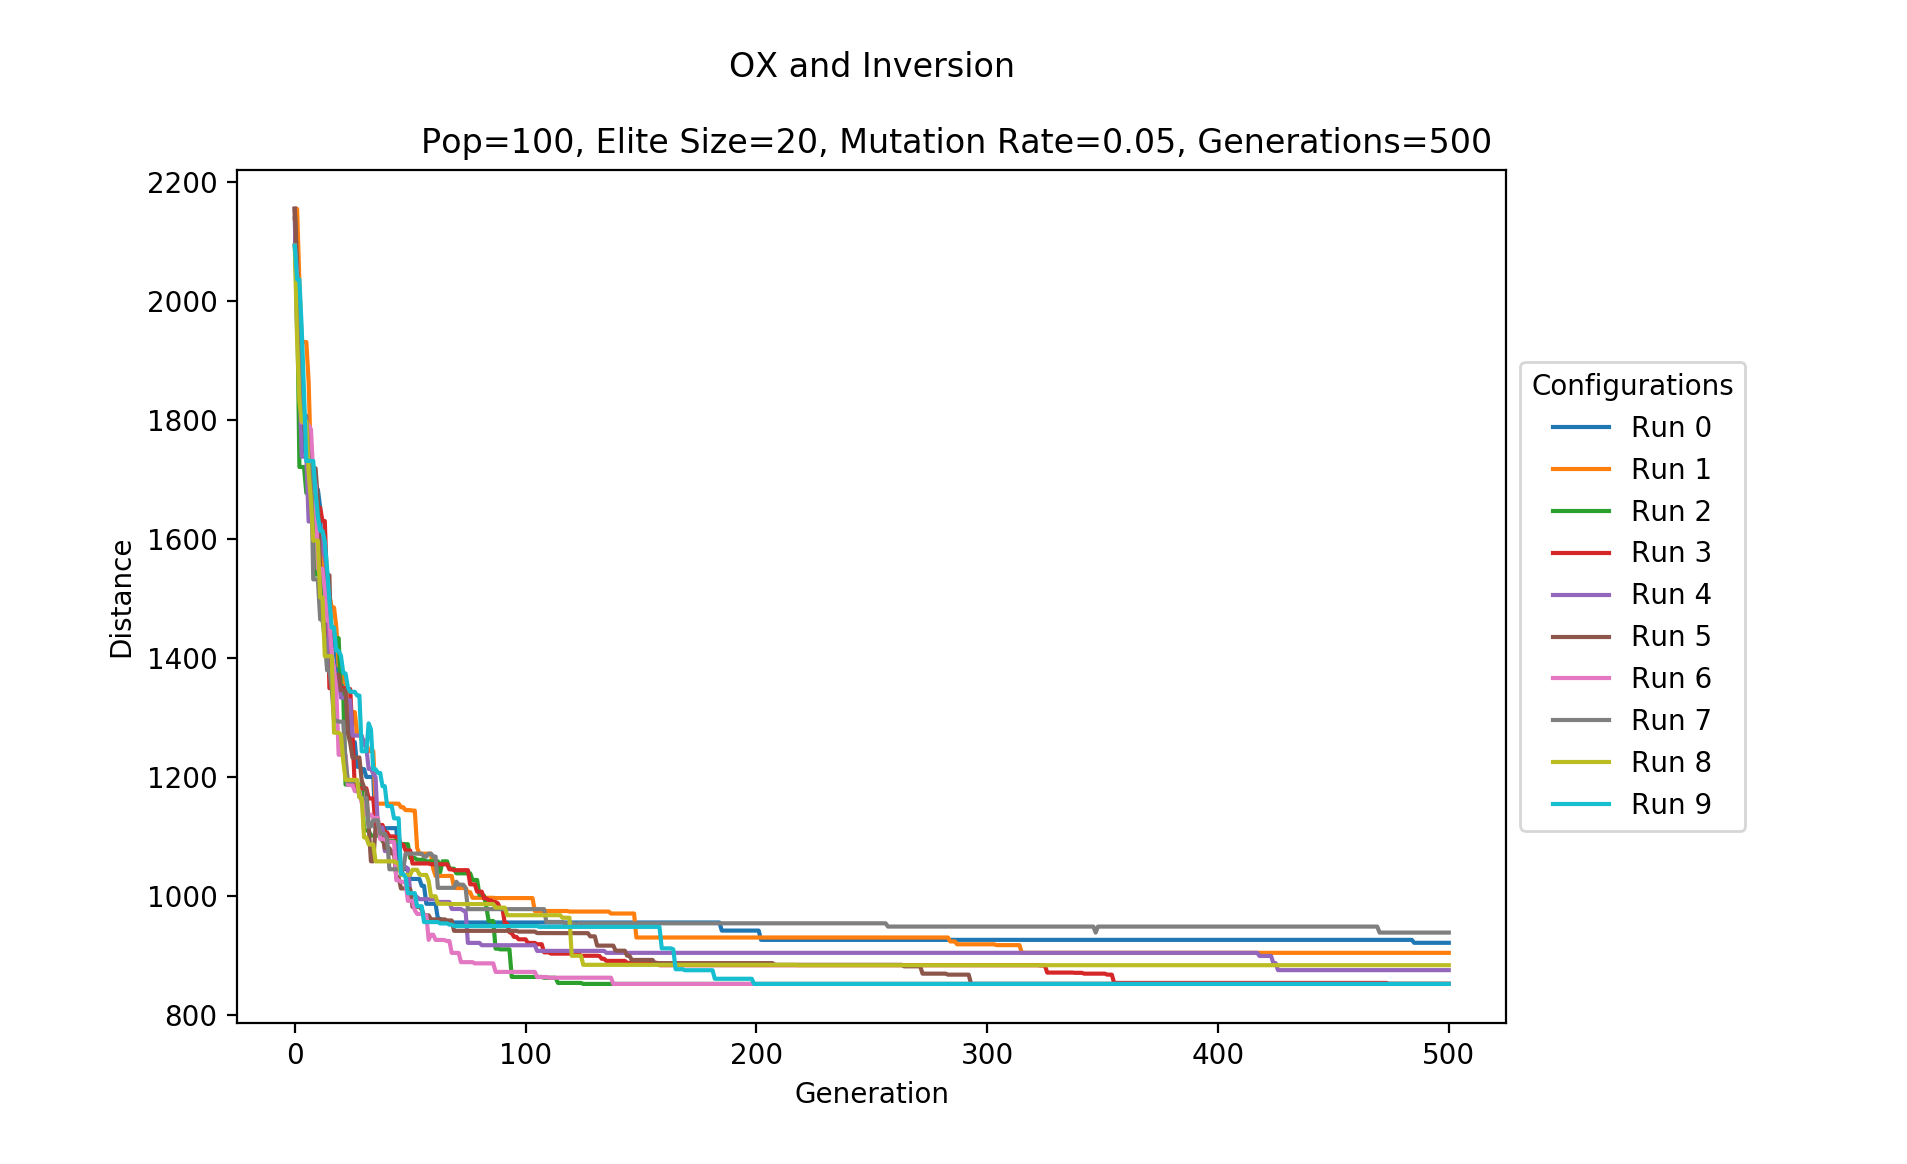

In [62]:
geneticAlgorithmVariationTest(population=pop, eliteSize=eliteSize, mutationRate=mutationRate, generations=generations, 
                              childMethod=2, mutationMethod=2, runs=10)

<IPython.core.display.Javascript object>


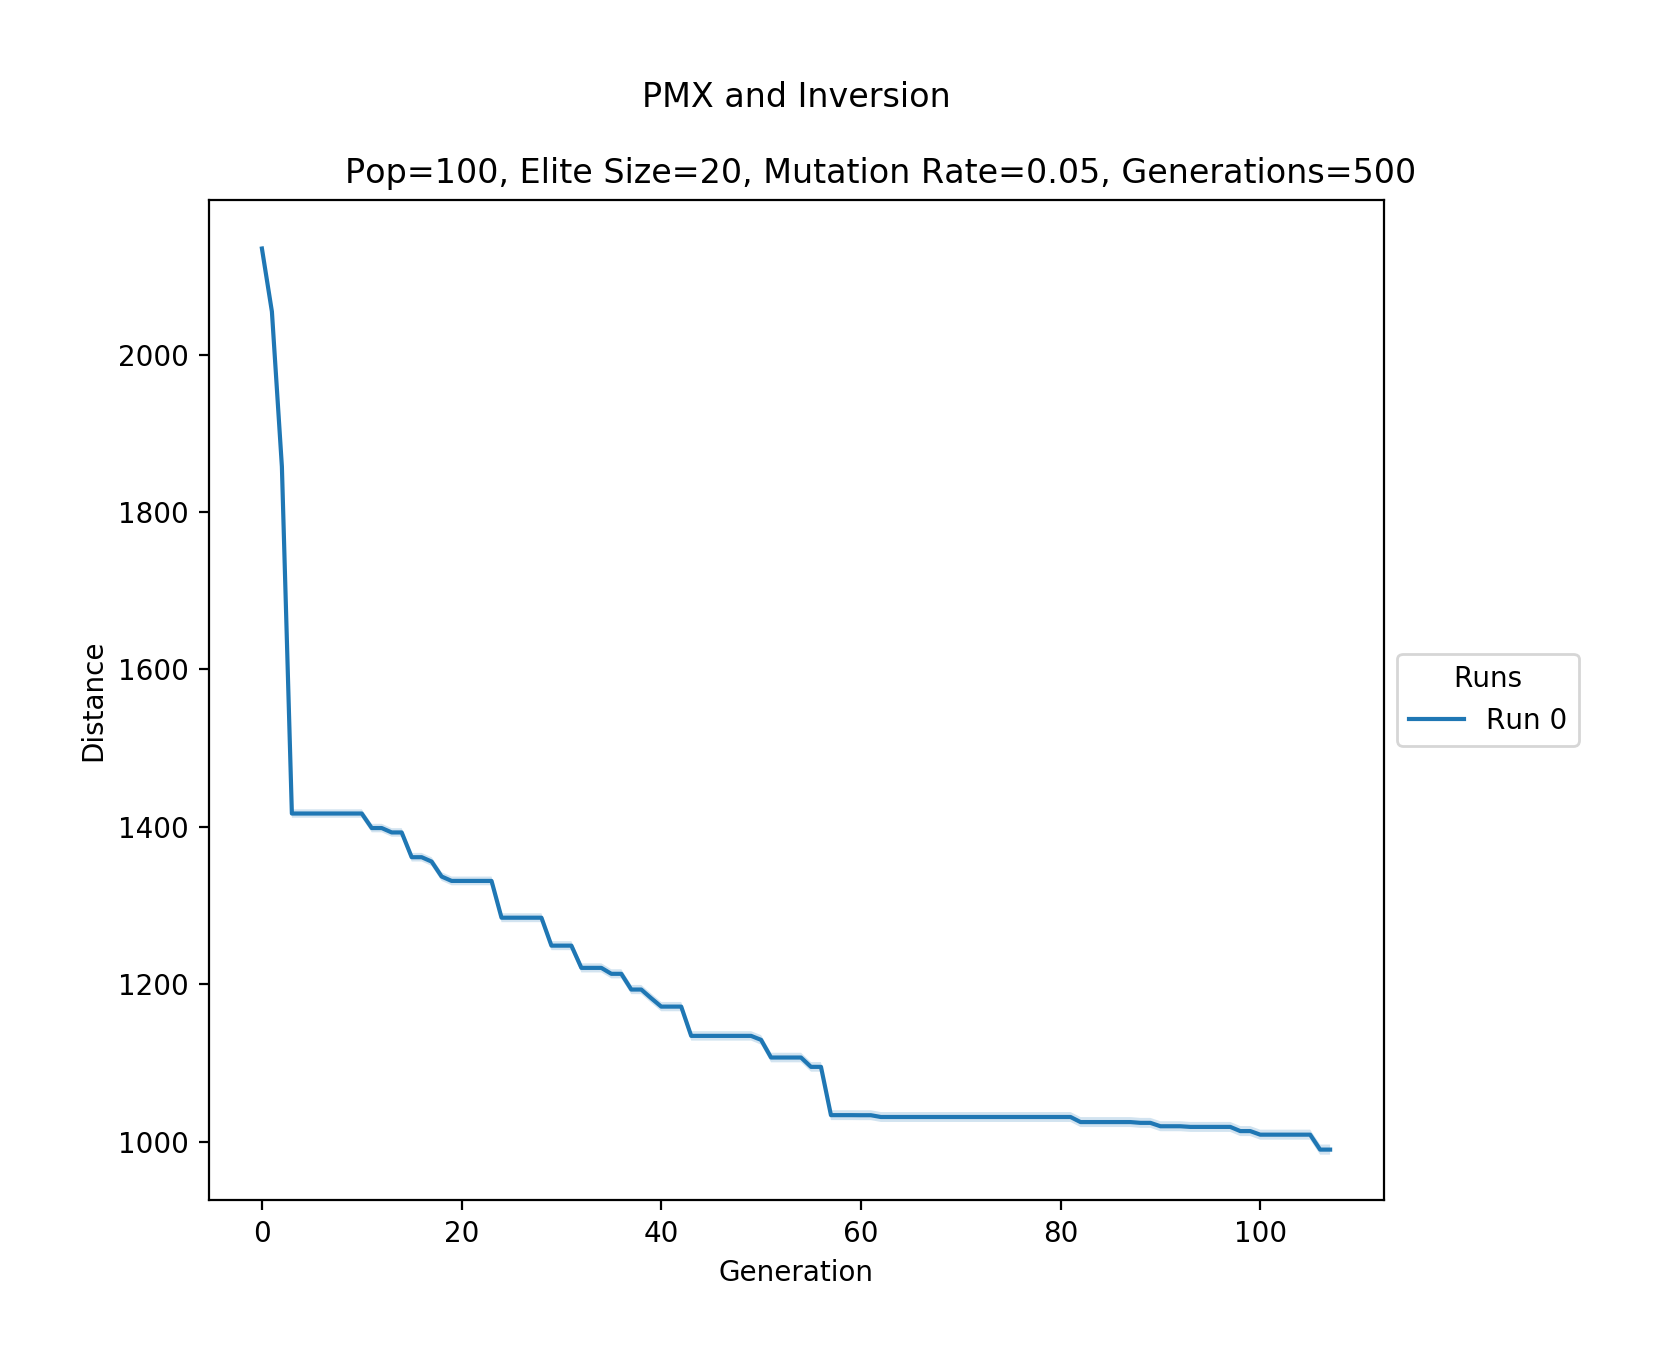

In [190]:
geneticAlgorithmVariationTest(population=pop, eliteSize=eliteSize, mutationRate=mutationRate, generations=generations, 
                              childMethod=0, mutationMethod=2, runs=1)

In [ ]:
geneticAlgorithmComparison(population=pop, eliteSize=eliteSize, mutationRate=mutationRate, generations=generations,
                               childMethods = childMethods, mutationMethods = mutationMethods)

In [ ]:
geneticAlgorithm(population=pop, eliteSize=eliteSize, mutationRate=mutationRate, generations=generations)

In [ ]:
geneticAlgorithmPlot(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)

In [ ]:
geneticAlgorithm(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)

In [ ]:
geneticAlgorithmPlot(population=pop, eliteSize=20, mutationRate=0.01, generations=500)

In [ ]:
#Generate more data for the graph
#geneticAlgorithmPlot(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)
geneticAlgorithmPlot(population=pop, eliteSize=20, mutationRate=0.01, generations=500)

In [ ]:
#The following are for testing purposes

In [ ]:
#Keeps saying that there is no modue named "logProcess"
#from logProcess import log_progress

In [ ]:
#Smaller group for testing the adding of methods
geneticAlgorithmPlot(population=cityList[0:10], popSize=20, eliteSize=5, mutationRate=0.01, generations=20)

In [ ]:
geneticAlgorithm(population=cityList[0:10], popSize=20, eliteSize=5, mutationRate=0.01, generations=20)

In [ ]:
city1 = City(0,1)
city2 = City(1,0)
city3 = City(0,2)
city4 = City(2,0)

In [ ]:
#The following is to test the recombination functions

In [ ]:
numberPop = [i for i in range(0, 25)]

In [ ]:
numberLists = []

for i in range(0, 100):
    numberLists.append(random.sample(numberPop, len(numberPop)))

In [ ]:
children = []

In [ ]:
p1 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
p2 = [2,15,12,5,17,9,14,6,10,16,3,11,7,4,8,1,13]

In [ ]:
p1 = [1,2,3,4,5,6,7,8,9]
p2 = [9,3,7,8,2,6,5,1,4]
p3 = [9,10,11,12,13,14,15,16,17]

In [ ]:
d = {'parent1': p1, 'parent2': p2}
df = pd.DataFrame(data=d)
df

In [ ]:
df["parent3"] = p3
df

In [138]:
p1 = [1,2,3,4,5,6,7,8,9,6,10,16]
p2 = [9,3,7,8,2,6,5,1,4]
p3 = [2,15,12,5,17,9,14,6,10,16,3,11,7,4,8,1,13]
df1 = pd.DataFrame(data = {"Item1": p1})
df2 = pd.DataFrame(data = {"Item2": p2})
df3 = pd.DataFrame(data = {"Item3": p3})

In [139]:
df = pd.concat([df1, df2, df3], axis = 1)
df

,Item1,Item2,Item3
0,1.0,9.0,2
1,2.0,3.0,15
2,3.0,7.0,12
3,4.0,8.0,5
4,5.0,2.0,17
5,6.0,6.0,9
6,7.0,5.0,14
7,8.0,1.0,6
8,9.0,4.0,10
9,6.0,NaN,16


In [150]:
dfStd = df.std(axis = 0)
dfStd

Item1    4.077841
Item2    2.738613
Item3    5.049752
dtype: float64

In [157]:
df2 = pd.DataFrame()

for column in df:
    df2[column] = [dfStd[column]] * len(df)
    
df2

,Item1,Item2,Item3
0,4.077841,2.738613,5.049752
1,4.077841,2.738613,5.049752
2,4.077841,2.738613,5.049752
3,4.077841,2.738613,5.049752
4,4.077841,2.738613,5.049752
5,4.077841,2.738613,5.049752
6,4.077841,2.738613,5.049752
7,4.077841,2.738613,5.049752
8,4.077841,2.738613,5.049752
9,4.077841,2.738613,5.049752


<IPython.core.display.Javascript object>


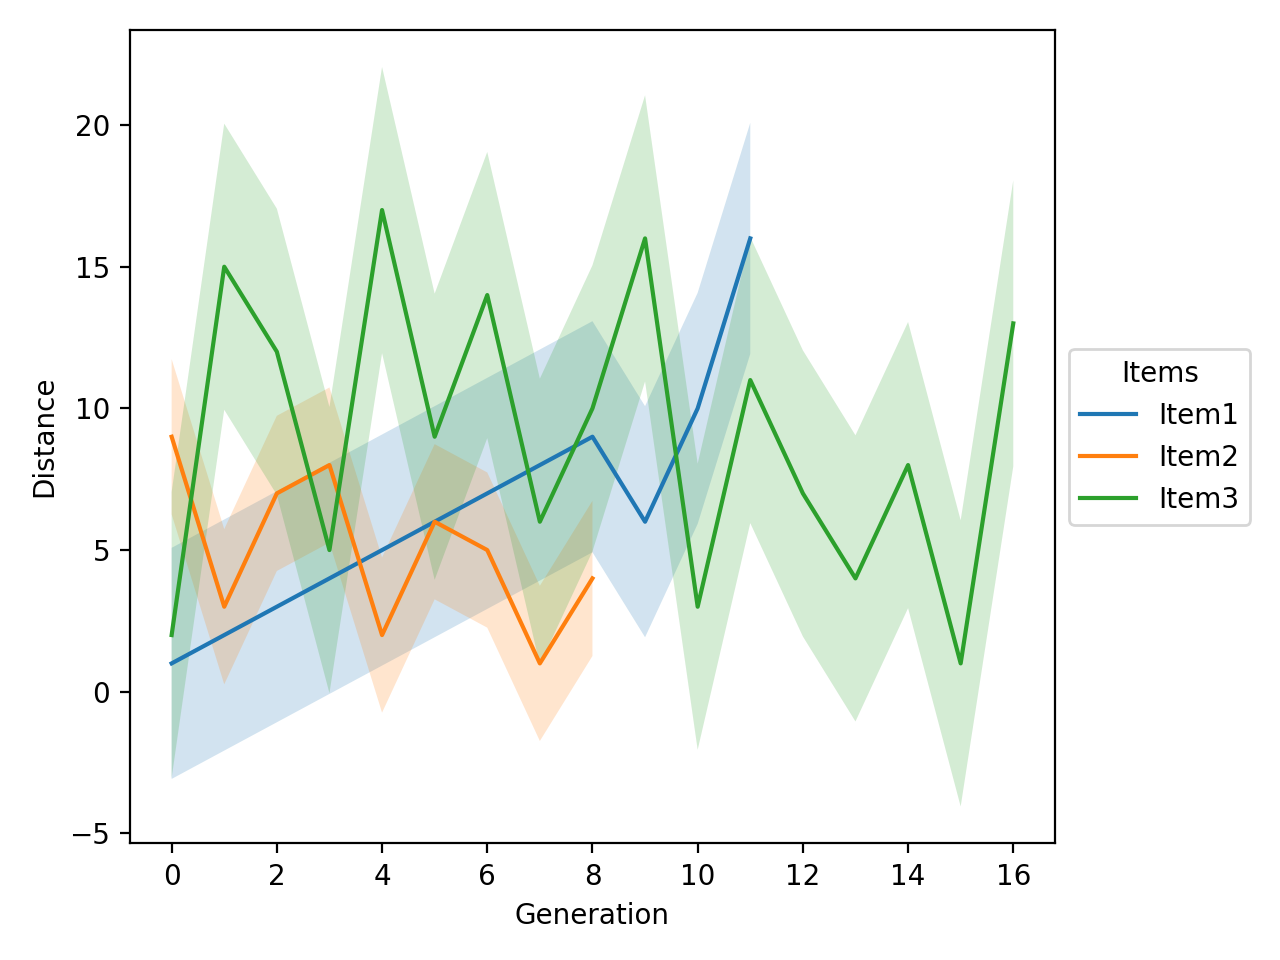

In [168]:
plt.plot(df)
plt.ylabel('Distance')
plt.xlabel('Generation')
plt.legend(df, loc = "center left", bbox_to_anchor=(1, 0.5), title="Items")

for column in df:
    plt.fill_between(df.index, df[column] - dfStd[column], df[column] + dfStd[column], alpha = 0.2)

#plt.fill_between(df.index, df["Item1"] - dfStd["Item1"], df["Item1"] + dfStd["Item1"], alpha = 0.2)

plt.tight_layout()
plt.show()

In [63]:
origValue = (126.37, 3)
newValue = (120.45, 4) 
per = (abs(origValue[0] - newValue[0])) / origValue[0]

per

0.04684656168394399

In [103]:
for column in df:
    print(f"column is: {column}")

column is: Item1
column is: Item2
column is: Item3


In [106]:
for column in dfStd:
    print(f"column is: {column}")

column is: 4.077841080619484
column is: 2.7386127875258306
column is: 5.049752469181039


In [119]:
df.iloc[1:5, 2:4]

,Item3
1,15
2,12
3,5
4,17


In [129]:
df.iloc[:, 0:1]

,Item1
0,1.0
1,2.0
2,3.0
3,4.0
4,5.0
5,6.0
6,7.0
7,8.0
8,9.0
9,6.0


In [134]:
dfStd.iloc[0:1]

Item1    4.077841
dtype: float64

In [135]:
dfStd["Item1"]

4.077841080619484

In [136]:
df["Item1"]

0      1.0
1      2.0
2      3.0
3      4.0
4      5.0
5      6.0
6      7.0
7      8.0
8      9.0
9      6.0
10    10.0
11    16.0
12     NaN
13     NaN
14     NaN
15     NaN
16     NaN
Name: Item1, dtype: float64

In [149]:
len(df)

17

In [165]:
df.index

RangeIndex(start=0, stop=17, step=1)